Black Carbon Analysis: FTIR EC/OC and HIPS Fabs Data Integration
 
This notebook analyzes the relationship between FTIR-based carbon measurements (EC, OC)
and HIPS-based light absorption measurements (Fabs) from the SPARTAN database.
We focus on samples where both measurement types are available.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime, timedelta
from scipy.stats import pearsonr
import os

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [29]:
# Configuration parameters
# Replace with actual path to your database file
DB_PATH = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/Combined Database/spartan_ftir_hips.db"
# Set the site of interest (change this to analyze a different site)
SITE_OF_INTEREST = "ETAD"

def load_data_from_db(db_path, site_code):
    """
    Load data from SQLite database for a specific site, ensuring we have both FTIR and HIPS measurements.
    
    Parameters:
    -----------
    db_path : str
        Path to the SQLite database file
    site_code : str
        Site code to filter data (e.g., "ETAD")
        
    Returns:
    --------
    DataFrame with filtered data
    """
    try:
        # Connect to database
        conn = sqlite3.connect(db_path)
        
        # First, check if the site exists
        site_query = "SELECT DISTINCT site_code FROM filters WHERE site_code = ?"
        site_exists = pd.read_sql_query(site_query, conn, params=(site_code,))
        
        if len(site_exists) == 0:
            print(f"Site '{site_code}' not found in database. Available sites:")
            all_sites = pd.read_sql_query("SELECT DISTINCT site_code FROM filters", conn)
            print(", ".join(all_sites['site_code'].tolist()))
            conn.close()
            return pd.DataFrame()
        
        # Query that joins filters with measurements for the specified site
        query = """
        SELECT 
            f.filter_id, 
            f.sample_date, 
            f.site_code,
            m.volume_m3,
            m.ec_ftir,
            m.ec_ftir_mdl,
            m.oc_ftir,
            m.oc_ftir_mdl,
            m.fabs,
            m.fabs_mdl,
            m.fabs_uncertainty,
            m.ftir_batch_id
        FROM 
            filters f
        JOIN 
            ftir_sample_measurements m USING(filter_id)
        WHERE 
            f.site_code = ? AND
            m.ec_ftir IS NOT NULL AND
            m.oc_ftir IS NOT NULL AND
            m.fabs IS NOT NULL
        ORDER BY 
            f.sample_date
        """
        
        # Execute query and load into DataFrame
        df = pd.read_sql_query(query, conn, params=(site_code,))
        
        # Convert date to datetime
        df['sample_date'] = pd.to_datetime(df['sample_date'])
        
        # Close connection
        conn.close()
        
        print(f"Loaded {len(df)} samples for site {site_code} with both FTIR and HIPS measurements")
        print(f"Date range: {df['sample_date'].min()} to {df['sample_date'].max()}")
        
        return df
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

# Load the data
data = load_data_from_db(DB_PATH, SITE_OF_INTEREST)

Loaded 162 samples for site ETAD with both FTIR and HIPS measurements
Date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00


In [30]:
# Basic data exploration
def explore_data(df, site_code):
    """
    Basic exploration of the loaded dataset for a specific site
    
    Parameters:
    -----------
    df : DataFrame
        Data for the site of interest
    site_code : str
        Site code for labeling
    """
    
    print(f"\n===== {site_code} Data Overview =====")
    print(f"Date range: {df['sample_date'].min()} to {df['sample_date'].max()}")
    print(f"Number of samples: {len(df)}")
    
    print("\n===== Missing Values =====")
    print(df.isnull().sum())
    
    print("\n===== Basic Statistics =====")
    stats = df[['ec_ftir', 'oc_ftir', 'fabs']].describe()
    print(stats)
    
    # Check for values below MDL
    below_mdl = {
        'EC': (df['ec_ftir'] < df['ec_ftir_mdl']).mean() * 100,
        'OC': (df['oc_ftir'] < df['oc_ftir_mdl']).mean() * 100,
        'Fabs': (df['fabs'] < df['fabs_mdl']).mean() * 100
    }
    print(f"\n===== Values Below MDL =====")
    for key, value in below_mdl.items():
        print(f"{key}: {value:.1f}% below MDL")
    
    # Create a data distributions figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # EC distribution
    sns.histplot(df['ec_ftir'], bins=20, kde=True, ax=axes[0])
    axes[0].set_title(f'{site_code} EC Distribution')
    axes[0].set_xlabel('EC (μg/m³)')
    
    # OC distribution
    sns.histplot(df['oc_ftir'], bins=20, kde=True, ax=axes[1])
    axes[1].set_title(f'{site_code} OC Distribution')
    axes[1].set_xlabel('OC (μg/m³)')
    
    # Fabs distribution
    sns.histplot(df['fabs'], bins=20, kde=True, ax=axes[2])
    axes[2].set_title(f'{site_code} Fabs Distribution')
    axes[2].set_xlabel('Fabs (Mm⁻¹)')
    
    plt.tight_layout()
    plt.show()
    
    return stats

In [31]:
# Handle values below MDL
def handle_mdl_values(df, method='conservative'):
    """
    Handle values below method detection limit (MDL)
    
    Parameters:
    -----------
    df : DataFrame
        Data to process
    method : str
        Method to handle below-MDL values:
        - 'conservative': Replace with MDL/2
        - 'strict': Set to NaN (will be excluded from analysis)
        - 'zero': Replace with 0
        
    Returns:
    --------
    DataFrame with processed values
    """
    df_processed = df.copy()
    
    for col, mdl_col in [('ec_ftir', 'ec_ftir_mdl'), 
                          ('oc_ftir', 'oc_ftir_mdl'),
                          ('fabs', 'fabs_mdl')]:
        
        # Identify values below MDL
        mask_below_mdl = df_processed[col] < df_processed[mdl_col]
        below_count = mask_below_mdl.sum()
        
        if below_count > 0:
            if method == 'conservative':
                df_processed.loc[mask_below_mdl, col] = df_processed.loc[mask_below_mdl, mdl_col] / 2
                print(f"Replaced {below_count} values below MDL in {col} with MDL/2")
            elif method == 'strict':
                df_processed.loc[mask_below_mdl, col] = np.nan
                print(f"Set {below_count} values below MDL in {col} to NaN")
            elif method == 'zero':
                df_processed.loc[mask_below_mdl, col] = 0
                print(f"Replaced {below_count} values below MDL in {col} with 0")
    
    return df_processed


In [32]:
def calculate_metrics(df):
    """
    Calculate additional metrics from the raw data
    
    Parameters:
    -----------
    df : DataFrame
        Data with EC, OC, and Fabs measurements
        
    Returns:
    --------
    DataFrame with additional calculated metrics
    """
    df_metrics = df.copy()
    
    # Calculate OC/EC ratio
    df_metrics['oc_ec_ratio'] = df_metrics['oc_ftir'] / df_metrics['ec_ftir']
    
    # Calculate MAC (Mass Absorption Cross-section)
    df_metrics['mac'] = df_metrics['fabs'] / df_metrics['ec_ftir']
    
    # Add month and season columns for seasonal analysis
    df_metrics['month'] = df_metrics['sample_date'].dt.month
    
    # Ethiopian season mapping function
    def map_ethiopian_seasons(month):
        """Maps month number to Ethiopian season name."""
        if month in [10, 11, 12, 1, 2]:
            return 'Dry Season'
        elif month in [3, 4, 5]:
            return 'Belg Rainy Season'
        else:  # months 6–9
            return 'Kiremt Rainy Season'
    
    df_metrics['season'] = df_metrics['month'].apply(map_ethiopian_seasons)
    
    # Clean extreme values that might be errors
    # Filter out extreme MAC values (typically > 50 m²/g would be suspicious)
    df_clean = df_metrics[df_metrics['mac'] < 50]
    
    # Filter out extreme OC/EC ratios
    df_clean = df_clean[df_clean['oc_ec_ratio'] < 20]
    
    if len(df_clean) < len(df_metrics):
        print(f"Removed {len(df_metrics) - len(df_clean)} samples with extreme values")
    
    return df_clean

In [33]:
def analyze_time_series(df, site_code):
    """
    Analyze time series of key metrics for a specific site
    
    Parameters:
    -----------
    df : DataFrame
        Data for the site of interest
    site_code : str
        Site code for labeling
        
    Returns:
    --------
    fig : Figure
        Time series plot figure
    monthly : DataFrame
        Monthly aggregated data
    """
    # Make sure we only include numeric columns for resampling
    numeric_cols = ['ec_ftir', 'oc_ftir', 'fabs', 'mac', 'oc_ec_ratio']
    df_numeric = df[numeric_cols].copy()
    
    # Group by month - use 'ME' instead of 'M' (month end)
    monthly = df_numeric.set_index(df['sample_date']).resample('ME').mean()
    
    # Rest of function is unchanged
    # Plot time series
    fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)
    
    # EC and OC
    ax1 = axes[0]
    ax1.plot(monthly.index, monthly['ec_ftir'], 'k-', label='EC', linewidth=2)
    ax1.plot(monthly.index, monthly['oc_ftir'], 'b-', label='OC', linewidth=2)
    ax1.set_ylabel('Concentration (μg/m³)')
    ax1.set_title(f'Site {site_code}: Monthly Average EC and OC Concentrations')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot individual data points as scatter
    ax1.scatter(df['sample_date'], df['ec_ftir'], color='gray', alpha=0.3, s=20, label='EC samples')
    ax1.scatter(df['sample_date'], df['oc_ftir'], color='lightblue', alpha=0.3, s=20, label='OC samples')
    
    # Fabs
    ax2 = axes[1]
    ax2.plot(monthly.index, monthly['fabs'], 'r-', linewidth=2)
    ax2.set_ylabel('Fabs (Mm⁻¹)')
    ax2.set_title(f'Site {site_code}: Monthly Average Light Absorption Coefficient')
    ax2.grid(True, alpha=0.3)
    
    # Plot individual data points as scatter
    ax2.scatter(df['sample_date'], df['fabs'], color='pink', alpha=0.3, s=20)
    
    # MAC
    ax3 = axes[2]
    ax3.plot(monthly.index, monthly['mac'], 'g-', linewidth=2)
    ax3.set_ylabel('MAC (m²/g)')
    ax3.set_xlabel('Date')
    ax3.set_title(f'Site {site_code}: Monthly Average Mass Absorption Cross-section')
    ax3.grid(True, alpha=0.3)
    
    # Plot individual data points as scatter
    ax3.scatter(df['sample_date'], df['mac'], color='lightgreen', alpha=0.3, s=20)
    
    plt.tight_layout()
    
    return fig, monthly

In [34]:
# Correlation analysis
def analyze_correlations(df, site_code):
    """
    Analyze correlations between key metrics for a specific site
    
    Parameters:
    -----------
    df : DataFrame
        Data for the site of interest
    site_code : str
        Site code for labeling
        
    Returns:
    --------
    fig : Figure
        Correlation analysis plot figure
    """
    
    # Create correlation scatter plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # EC vs Fabs
    ax1 = axes[0, 0]
    ax1.scatter(df['ec_ftir'], df['fabs'], alpha=0.7, s=70, c='darkred')
    ax1.set_xlabel('EC (μg/m³)')
    ax1.set_ylabel('Fabs (Mm⁻¹)')
    ax1.set_title(f'Site {site_code}: EC vs Light Absorption (Fabs)')
    
    # Add regression line
    if len(df) > 2:
        m, b = np.polyfit(df['ec_ftir'], df['fabs'], 1)
        x_line = np.linspace(df['ec_ftir'].min(), df['ec_ftir'].max(), 100)
        ax1.plot(x_line, m * x_line + b, 'k-', linewidth=2)
        
        # Calculate correlation
        r, p = pearsonr(df['ec_ftir'], df['fabs'])
        ax1.text(0.05, 0.95, f'r = {r:.3f}\np = {p:.3g}\nMAC = {m:.2f} m²/g', 
                 transform=ax1.transAxes, verticalalignment='top', 
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # OC vs Fabs
    ax2 = axes[0, 1]
    ax2.scatter(df['oc_ftir'], df['fabs'], alpha=0.7, s=70, c='darkblue')
    ax2.set_xlabel('OC (μg/m³)')
    ax2.set_ylabel('Fabs (Mm⁻¹)')
    ax2.set_title(f'Site {site_code}: OC vs Light Absorption (Fabs)')
    
    # Add regression line
    if len(df) > 2:
        m, b = np.polyfit(df['oc_ftir'], df['fabs'], 1)
        x_line = np.linspace(df['oc_ftir'].min(), df['oc_ftir'].max(), 100)
        ax2.plot(x_line, m * x_line + b, 'k-', linewidth=2)
        
        # Calculate correlation
        r, p = pearsonr(df['oc_ftir'], df['fabs'])
        ax2.text(0.05, 0.95, f'r = {r:.3f}\np = {p:.3g}\nslope = {m:.2f}', 
                 transform=ax2.transAxes, verticalalignment='top', 
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # OC/EC ratio vs MAC
    ax3 = axes[1, 0]
    ax3.scatter(df['oc_ec_ratio'], df['mac'], alpha=0.7, s=70, c='purple')
    ax3.set_xlabel('OC/EC Ratio')
    ax3.set_ylabel('MAC (m²/g)')
    ax3.set_title(f'Site {site_code}: OC/EC Ratio vs Mass Absorption Cross-section')
    
    # Add regression line
    if len(df) > 2:
        m, b = np.polyfit(df['oc_ec_ratio'], df['mac'], 1)
        x_line = np.linspace(df['oc_ec_ratio'].min(), df['oc_ec_ratio'].max(), 100)
        ax3.plot(x_line, m * x_line + b, 'k-', linewidth=2)
        
        # Calculate correlation
        r, p = pearsonr(df['oc_ec_ratio'], df['mac'])
        ax3.text(0.05, 0.95, f'r = {r:.3f}\np = {p:.3g}\nslope = {m:.2f}', 
                 transform=ax3.transAxes, verticalalignment='top', 
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # MAC distribution
    ax4 = axes[1, 1]
    sns.histplot(df['mac'], bins=20, kde=True, ax=ax4, color='forestgreen')
    ax4.set_xlabel('MAC (m²/g)')
    ax4.set_ylabel('Frequency')
    ax4.set_title(f'Site {site_code}: Distribution of Mass Absorption Cross-section')
    ax4.axvline(df['mac'].mean(), color='red', linestyle='--', linewidth=2)
    ax4.text(0.7, 0.95, f'Mean: {df["mac"].mean():.2f} m²/g\nMedian: {df["mac"].median():.2f} m²/g', 
             transform=ax4.transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    return fig


In [35]:
def analyze_seasonal_patterns(df, site_code):
    """
    Analyze seasonal patterns in the data for a specific site
    
    Parameters:
    -----------
    df : DataFrame
        Data for the site of interest
    site_code : str
        Site code for labeling
        
    Returns:
    --------
    fig : Figure
        Seasonal analysis plot figure
    seasonal : DataFrame
        Data aggregated by season
    """
    
    # Group by season and calculate means
    seasonal = df.groupby('season')[['ec_ftir', 'oc_ftir', 'fabs', 'mac', 'oc_ec_ratio']].mean()
    
    # Calculate sample counts per season
    season_counts = df['season'].value_counts()
    seasonal['sample_count'] = season_counts
    
    # Reorder seasons - Ethiopian seasons
    season_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
    seasonal = seasonal.reindex(season_order)
    
    # Rest of function remains the same...
    # Create seasonal bar plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # EC and OC by season
    ax1 = axes[0, 0]
    seasonal[['ec_ftir', 'oc_ftir']].plot(kind='bar', ax=ax1, color=['black', 'blue'])
    ax1.set_ylabel('Concentration (μg/m³)')
    ax1.set_title(f'Site {site_code}: Seasonal EC and OC Concentrations')
    ax1.set_xlabel('')
    
    # Add sample count annotations
    for i, count in enumerate(seasonal['sample_count']):
        ax1.annotate(f'n={count}', xy=(i, 0.1), ha='center', va='bottom',
                    xytext=(0, 5), textcoords='offset points')
    
    # Fabs by season
    ax2 = axes[0, 1]
    seasonal['fabs'].plot(kind='bar', ax=ax2, color='darkred')
    ax2.set_ylabel('Fabs (Mm⁻¹)')
    ax2.set_title(f'Site {site_code}: Seasonal Light Absorption Coefficient')
    ax2.set_xlabel('')
    
    # Add sample count annotations
    for i, count in enumerate(seasonal['sample_count']):
        ax2.annotate(f'n={count}', xy=(i, 0.1), ha='center', va='bottom',
                    xytext=(0, 5), textcoords='offset points')
    
    # MAC by season
    ax3 = axes[1, 0]
    seasonal['mac'].plot(kind='bar', ax=ax3, color='darkgreen')
    ax3.set_ylabel('MAC (m²/g)')
    ax3.set_title(f'Site {site_code}: Seasonal Mass Absorption Cross-section')
    ax3.set_xlabel('')
    
    # Add sample count annotations
    for i, count in enumerate(seasonal['sample_count']):
        ax3.annotate(f'n={count}', xy=(i, 0.1), ha='center', va='bottom',
                    xytext=(0, 5), textcoords='offset points')
    
    # OC/EC ratio by season
    ax4 = axes[1, 1]
    seasonal['oc_ec_ratio'].plot(kind='bar', ax=ax4, color='purple')
    ax4.set_ylabel('OC/EC Ratio')
    ax4.set_title(f'Site {site_code}: Seasonal OC/EC Ratio')
    ax4.set_xlabel('')
    
    # Add sample count annotations
    for i, count in enumerate(seasonal['sample_count']):
        ax4.annotate(f'n={count}', xy=(i, 0.1), ha='center', va='bottom',
                    xytext=(0, 5), textcoords='offset points')
    
    plt.tight_layout()
    
    # Create a box plot figure to show distributions by season
    fig2, axes2 = plt.subplots(2, 2, figsize=(16, 14))
    
    # EC by season boxplot
    sns.boxplot(x='season', y='ec_ftir', data=df, ax=axes2[0, 0], order=season_order)
    axes2[0, 0].set_title(f'Site {site_code}: EC Distribution by Season')
    axes2[0, 0].set_ylabel('EC (μg/m³)')
    
    # Fabs by season boxplot
    sns.boxplot(x='season', y='fabs', data=df, ax=axes2[0, 1], order=season_order)
    axes2[0, 1].set_title(f'Site {site_code}: Fabs Distribution by Season')
    axes2[0, 1].set_ylabel('Fabs (Mm⁻¹)')
    
    # MAC by season boxplot
    sns.boxplot(x='season', y='mac', data=df, ax=axes2[1, 0], order=season_order)
    axes2[1, 0].set_title(f'Site {site_code}: MAC Distribution by Season')
    axes2[1, 0].set_ylabel('MAC (m²/g)')
    
    # OC/EC ratio by season boxplot
    sns.boxplot(x='season', y='oc_ec_ratio', data=df, ax=axes2[1, 1], order=season_order)
    axes2[1, 1].set_title(f'Site {site_code}: OC/EC Ratio Distribution by Season')
    axes2[1, 1].set_ylabel('OC/EC Ratio')
    
    plt.tight_layout()
    
    # Show both figures
    plt.figure(fig.number)
    plt.show()
    plt.figure(fig2.number)
    plt.show()
    
    return fig, seasonal

In [36]:
# Site comparison analysis
def compare_sites(df):
    """Compare metrics across different sites"""
    
    # Group by site and calculate means
    sites = df.groupby('site_code')[['ec_ftir', 'oc_ftir', 'fabs', 'mac', 'oc_ec_ratio']].mean()
    
    # Calculate sample counts per site
    sample_counts = df['site_code'].value_counts()
    sites['sample_count'] = sample_counts
    
    # Sort by sample count
    sites = sites.sort_values('sample_count', ascending=False)
    
    # Create site comparison plots
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    
    # EC by site
    ax1 = axes[0, 0]
    sites['ec_ftir'].plot(kind='bar', ax=ax1, color='k')
    ax1.set_ylabel('EC (μg/m³)')
    ax1.set_title('Average EC by Site')
    ax1.set_xlabel('')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # OC by site
    ax2 = axes[0, 1]
    sites['oc_ftir'].plot(kind='bar', ax=ax2, color='b')
    ax2.set_ylabel('OC (μg/m³)')
    ax2.set_title('Average OC by Site')
    ax2.set_xlabel('')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    
    # Fabs by site
    ax3 = axes[1, 0]
    sites['fabs'].plot(kind='bar', ax=ax3, color='r')
    ax3.set_ylabel('Fabs (Mm⁻¹)')
    ax3.set_title('Average Light Absorption Coefficient by Site')
    ax3.set_xlabel('')
    plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')
    
    # MAC by site
    ax4 = axes[1, 1]
    sites['mac'].plot(kind='bar', ax=ax4, color='g')
    ax4.set_ylabel('MAC (m²/g)')
    ax4.set_title('Average Mass Absorption Cross-section by Site')
    ax4.set_xlabel('')
    plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')
    
    # OC/EC ratio by site
    ax5 = axes[2, 0]
    sites['oc_ec_ratio'].plot(kind='bar', ax=ax5, color='purple')
    ax5.set_ylabel('OC/EC Ratio')
    ax5.set_title('Average OC/EC Ratio by Site')
    ax5.set_xlabel('')
    plt.setp(ax5.get_xticklabels(), rotation=45, ha='right')
    
    # Sample counts by site
    ax6 = axes[2, 1]
    sites['sample_count'].plot(kind='bar', ax=ax6, color='orange')
    ax6.set_ylabel('Number of Samples')
    ax6.set_title('Sample Count by Site')
    ax6.set_xlabel('')
    plt.setp(ax6.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    
    return fig, sites


In [37]:
# Also fix the trend analysis function the same way:
def analyze_trends(df, site_code):
    """
    Analyze long-term trends in the data for a specific site
    
    Parameters:
    -----------
    df : DataFrame
        Data for the site of interest
    site_code : str
        Site code for labeling
        
    Returns:
    --------
    fig : Figure
        Trend analysis plot figure
    yearly : DataFrame
        Data aggregated by year
    """
    # Make sure we only include numeric columns for resampling
    numeric_cols = ['ec_ftir', 'oc_ftir', 'fabs', 'mac', 'oc_ec_ratio']
    df_numeric = df[numeric_cols].copy()
    
    # Group by year - use 'YE' (year end) instead of 'Y'
    yearly = df_numeric.set_index(df['sample_date']).resample('YE').mean()
    
    # Rest of the function remains the same...
    # Create trend plots
    fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)
    
    # EC and OC trends
    ax1 = axes[0]
    ax1.plot(yearly.index, yearly['ec_ftir'], 'k-', label='EC', linewidth=2, marker='o', markersize=8)
    ax1.plot(yearly.index, yearly['oc_ftir'], 'b-', label='OC', linewidth=2, marker='s', markersize=8)
    ax1.set_ylabel('Concentration (μg/m³)')
    ax1.set_title(f'Site {site_code}: Yearly Average EC and OC Trends')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add regression lines if we have enough years
    if len(yearly) > 2:
        # For EC
        x_num = np.arange(len(yearly))
        m_ec, b_ec = np.polyfit(x_num, yearly['ec_ftir'].values, 1)
        ax1.plot(yearly.index, m_ec * x_num + b_ec, 'k--', linewidth=1)
        
        # For OC
        m_oc, b_oc = np.polyfit(x_num, yearly['oc_ftir'].values, 1)
        ax1.plot(yearly.index, m_oc * x_num + b_oc, 'b--', linewidth=1)
        
        # Add trend rates to legend
        ec_change = m_ec / yearly['ec_ftir'].mean() * 100
        oc_change = m_oc / yearly['oc_ftir'].mean() * 100
        ax1.text(0.02, 0.95, f"EC trend: {ec_change:.1f}% per year\nOC trend: {oc_change:.1f}% per year", 
                transform=ax1.transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    # Fabs trend
    ax2 = axes[1]
    ax2.plot(yearly.index, yearly['fabs'], 'r-', linewidth=2, marker='o', markersize=8)
    ax2.set_ylabel('Fabs (Mm⁻¹)')
    ax2.set_title(f'Site {site_code}: Yearly Average Light Absorption Coefficient Trend')
    ax2.grid(True, alpha=0.3)
    
    # Add regression line if we have enough years
    if len(yearly) > 2:
        m_fabs, b_fabs = np.polyfit(x_num, yearly['fabs'].values, 1)
        ax2.plot(yearly.index, m_fabs * x_num + b_fabs, 'r--', linewidth=1)
        
        # Add trend rate to plot
        fabs_change = m_fabs / yearly['fabs'].mean() * 100
        ax2.text(0.02, 0.95, f"Fabs trend: {fabs_change:.1f}% per year", 
                transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    # MAC trend
    ax3 = axes[2]
    ax3.plot(yearly.index, yearly['mac'], 'g-', linewidth=2, marker='o', markersize=8)
    ax3.set_ylabel('MAC (m²/g)')
    ax3.set_xlabel('Year')
    ax3.set_title(f'Site {site_code}: Yearly Average Mass Absorption Cross-section Trend')
    ax3.grid(True, alpha=0.3)
    
    # Add regression line if we have enough years
    if len(yearly) > 2:
        m_mac, b_mac = np.polyfit(x_num, yearly['mac'].values, 1)
        ax3.plot(yearly.index, m_mac * x_num + b_mac, 'g--', linewidth=1)
        
        # Add trend rate to plot
        mac_change = m_mac / yearly['mac'].mean() * 100
        ax3.text(0.02, 0.95, f"MAC trend: {mac_change:.1f}% per year", 
                transform=ax3.transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    # Create a DataFrame to summarize trends
    if len(yearly) > 2:
        trend_summary = pd.DataFrame({
            'Metric': ['EC', 'OC', 'Fabs', 'MAC'],
            'Mean': [yearly['ec_ftir'].mean(), yearly['oc_ftir'].mean(), 
                     yearly['fabs'].mean(), yearly['mac'].mean()],
            'Annual Change': [m_ec, m_oc, m_fabs, m_mac],
            'Percent Change': [ec_change, oc_change, fabs_change, mac_change]
        })
        
        print("\n===== Trend Summary =====")
        print(trend_summary[['Metric', 'Mean', 'Annual Change', 'Percent Change']].round(3))
    
    return fig, yearly

Loaded 162 samples for site ETAD with both FTIR and HIPS measurements
Date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00

===== ETAD Data Overview =====
Date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00
Number of samples: 162

===== Missing Values =====
filter_id           0
sample_date         0
site_code           0
volume_m3           0
ec_ftir             0
ec_ftir_mdl         0
oc_ftir             0
oc_ftir_mdl         0
fabs                0
fabs_mdl            0
fabs_uncertainty    0
ftir_batch_id       0
dtype: int64

===== Basic Statistics =====
          ec_ftir     oc_ftir        fabs
count  162.000000  162.000000  162.000000
mean     4.663528    6.281690   47.258976
std      2.034262    2.849580    9.739997
min      0.693115    0.617765   28.085699
25%      3.046502    4.232311   40.238902
50%      4.049773    5.530220   45.859240
75%      6.009214    7.416377   52.977287
max     10.533354   15.332336   74.191711

===== Values Below MDL =====
EC: 0.0% below MDL
OC:

/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_46398/2881706158.py:53: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


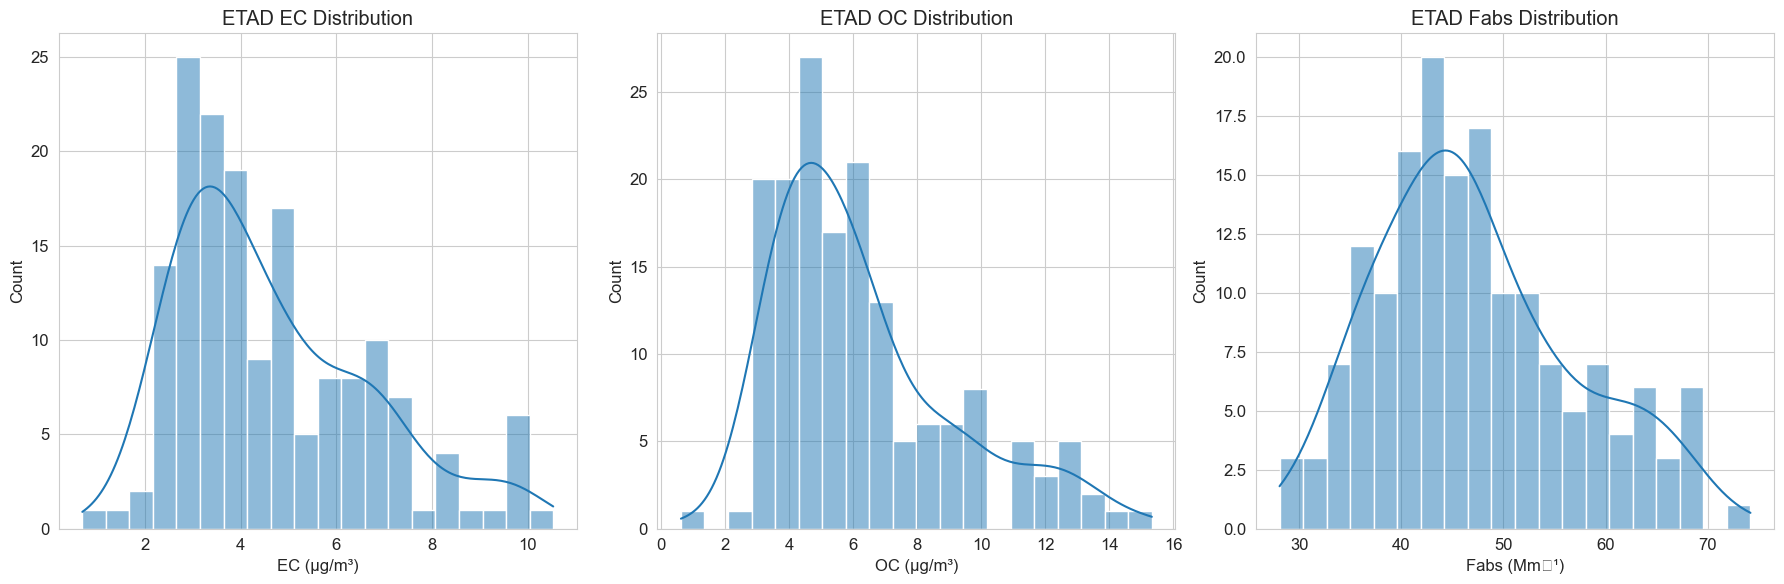

Replaced 1 values below MDL in oc_ftir with MDL/2
Removed 1 samples with extreme values

===== Analysis for Site ETAD =====
Number of samples after processing: 161

----- Time Series Analysis -----


/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_46398/2217143362.py:64: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


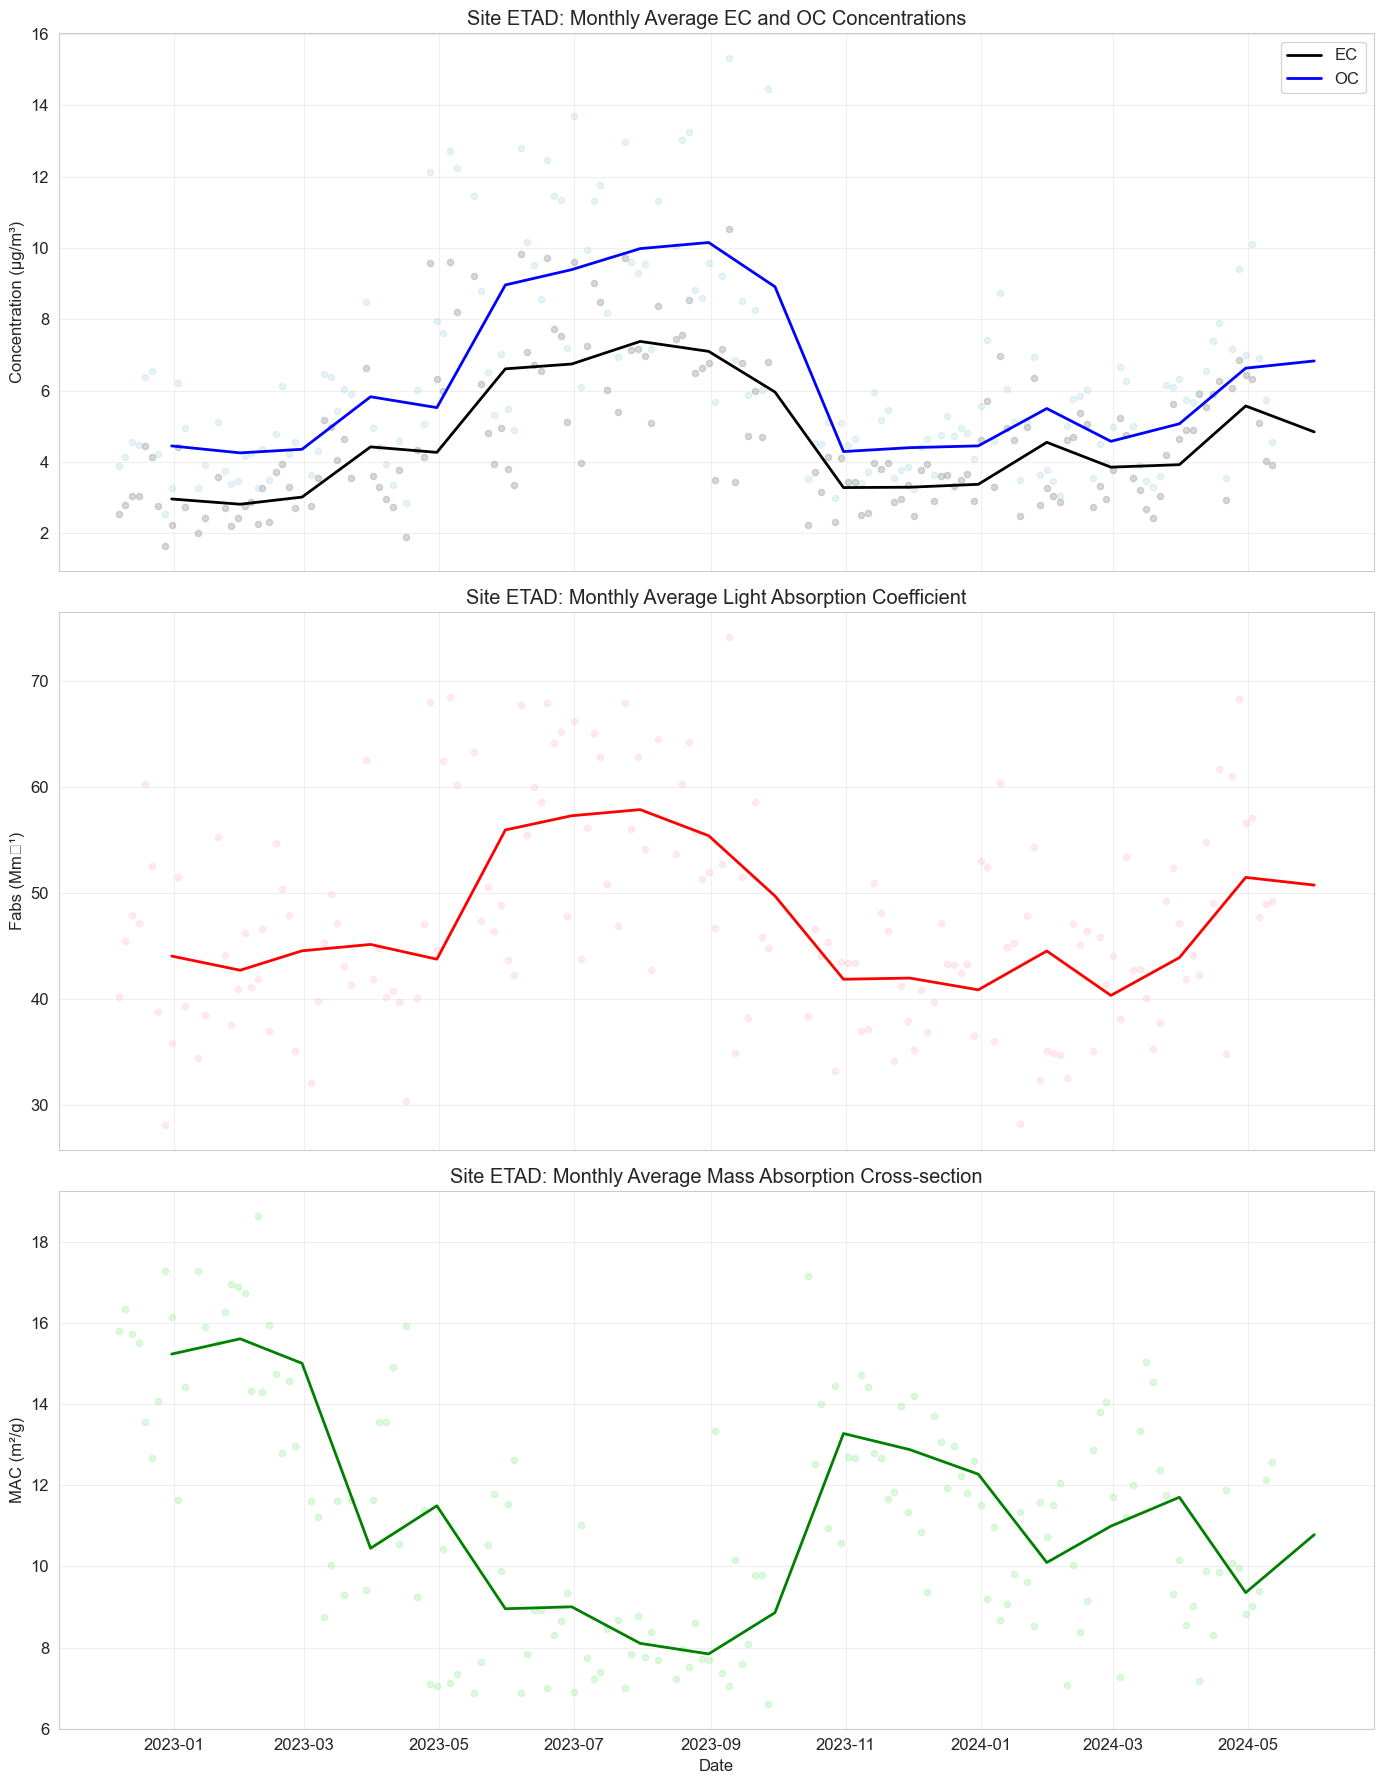


----- Correlation Analysis -----


/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_46398/1468801316.py:90: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


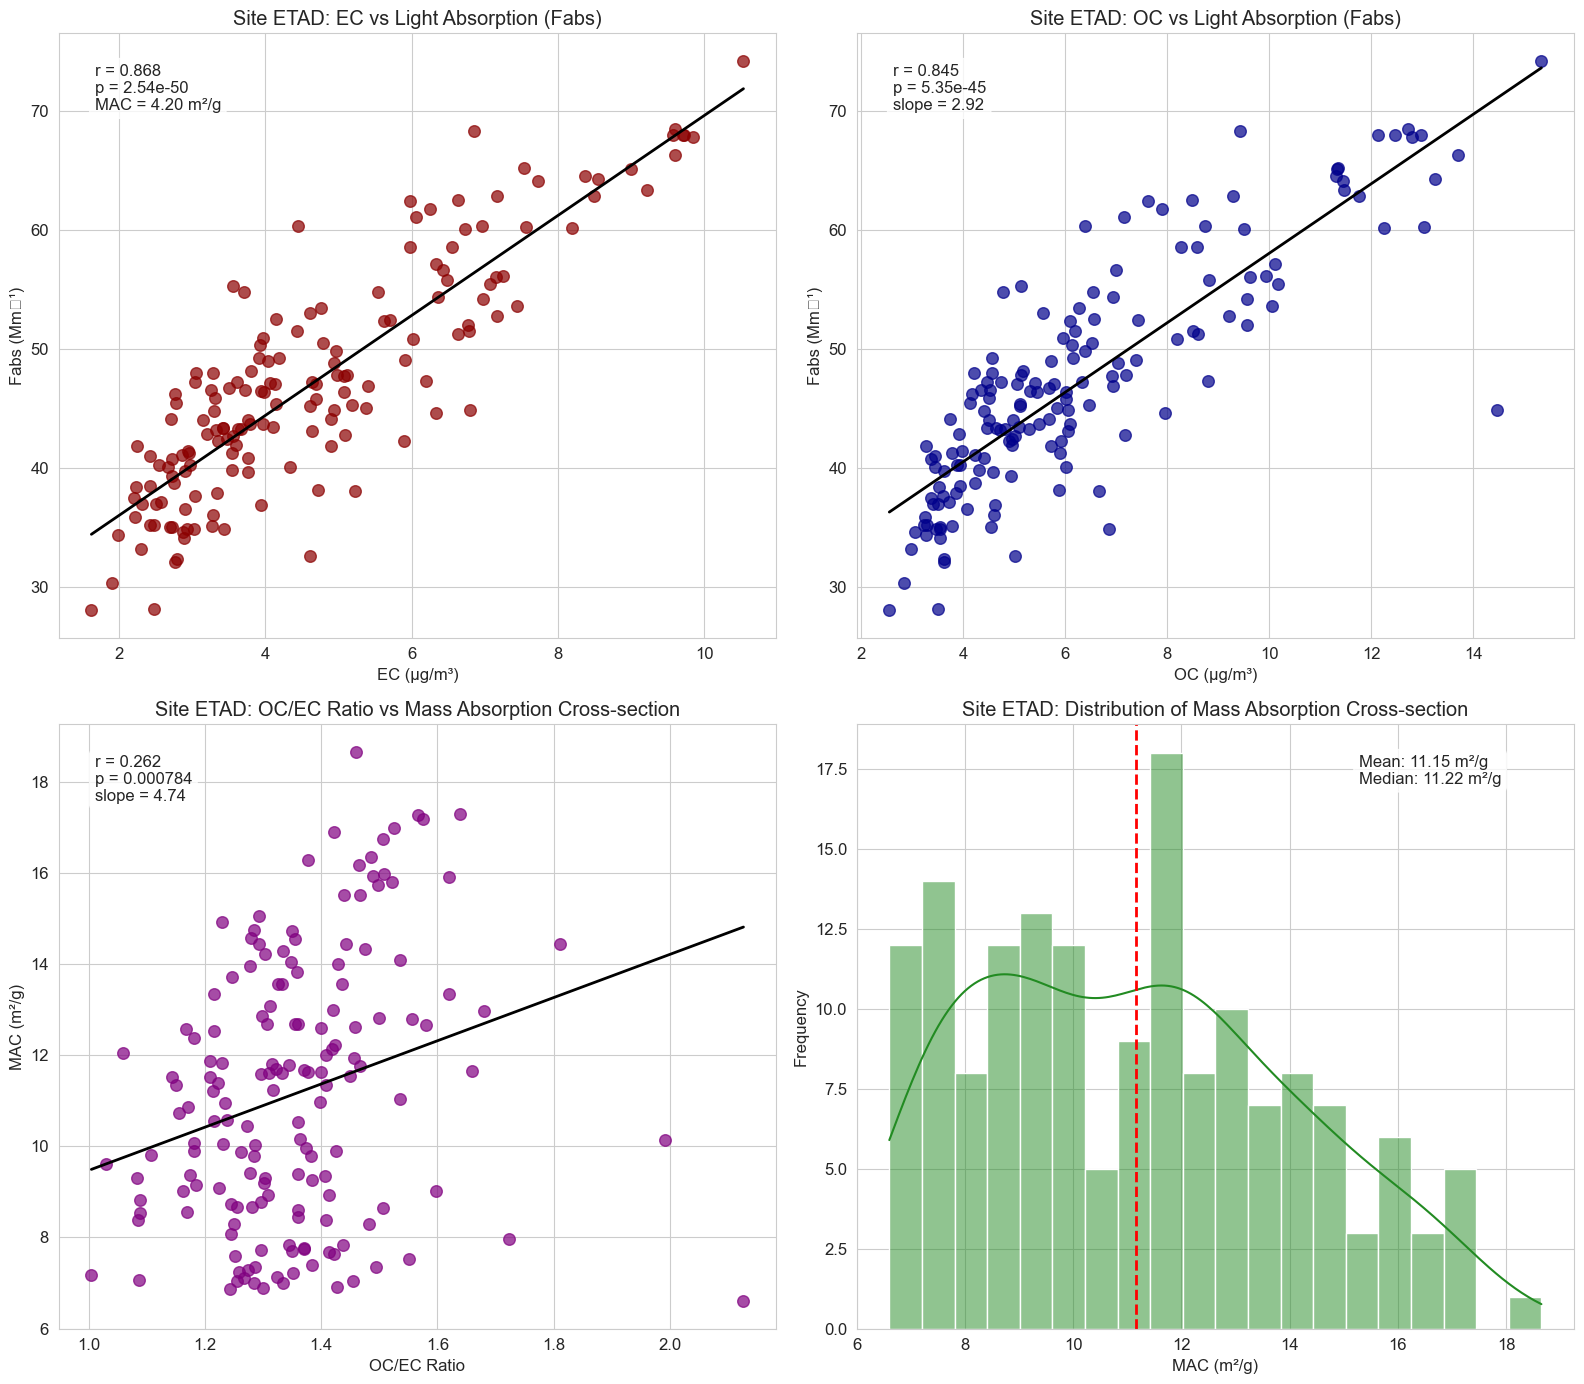

/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_46398/1767370489.py:83: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_46398/1767370489.py:108: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()



----- Seasonal Analysis -----


/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


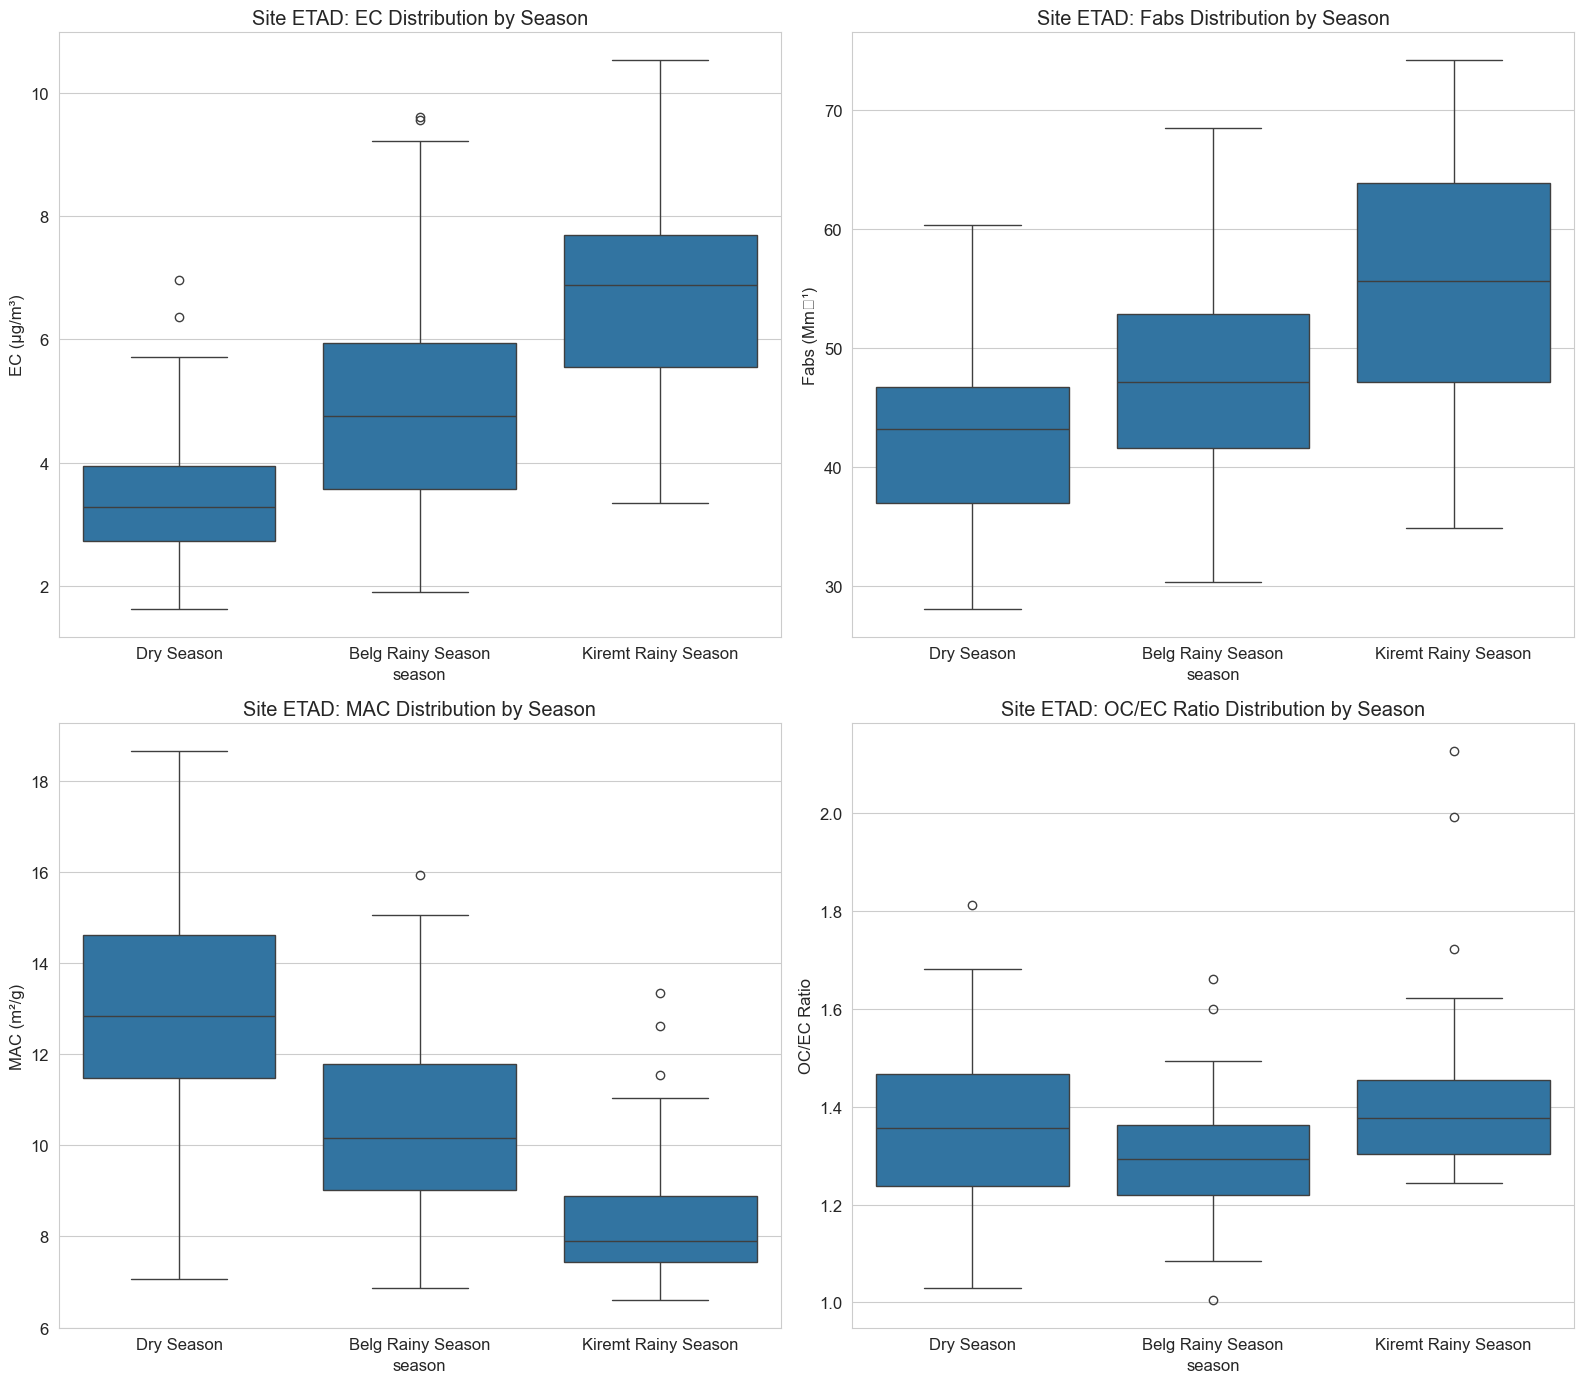

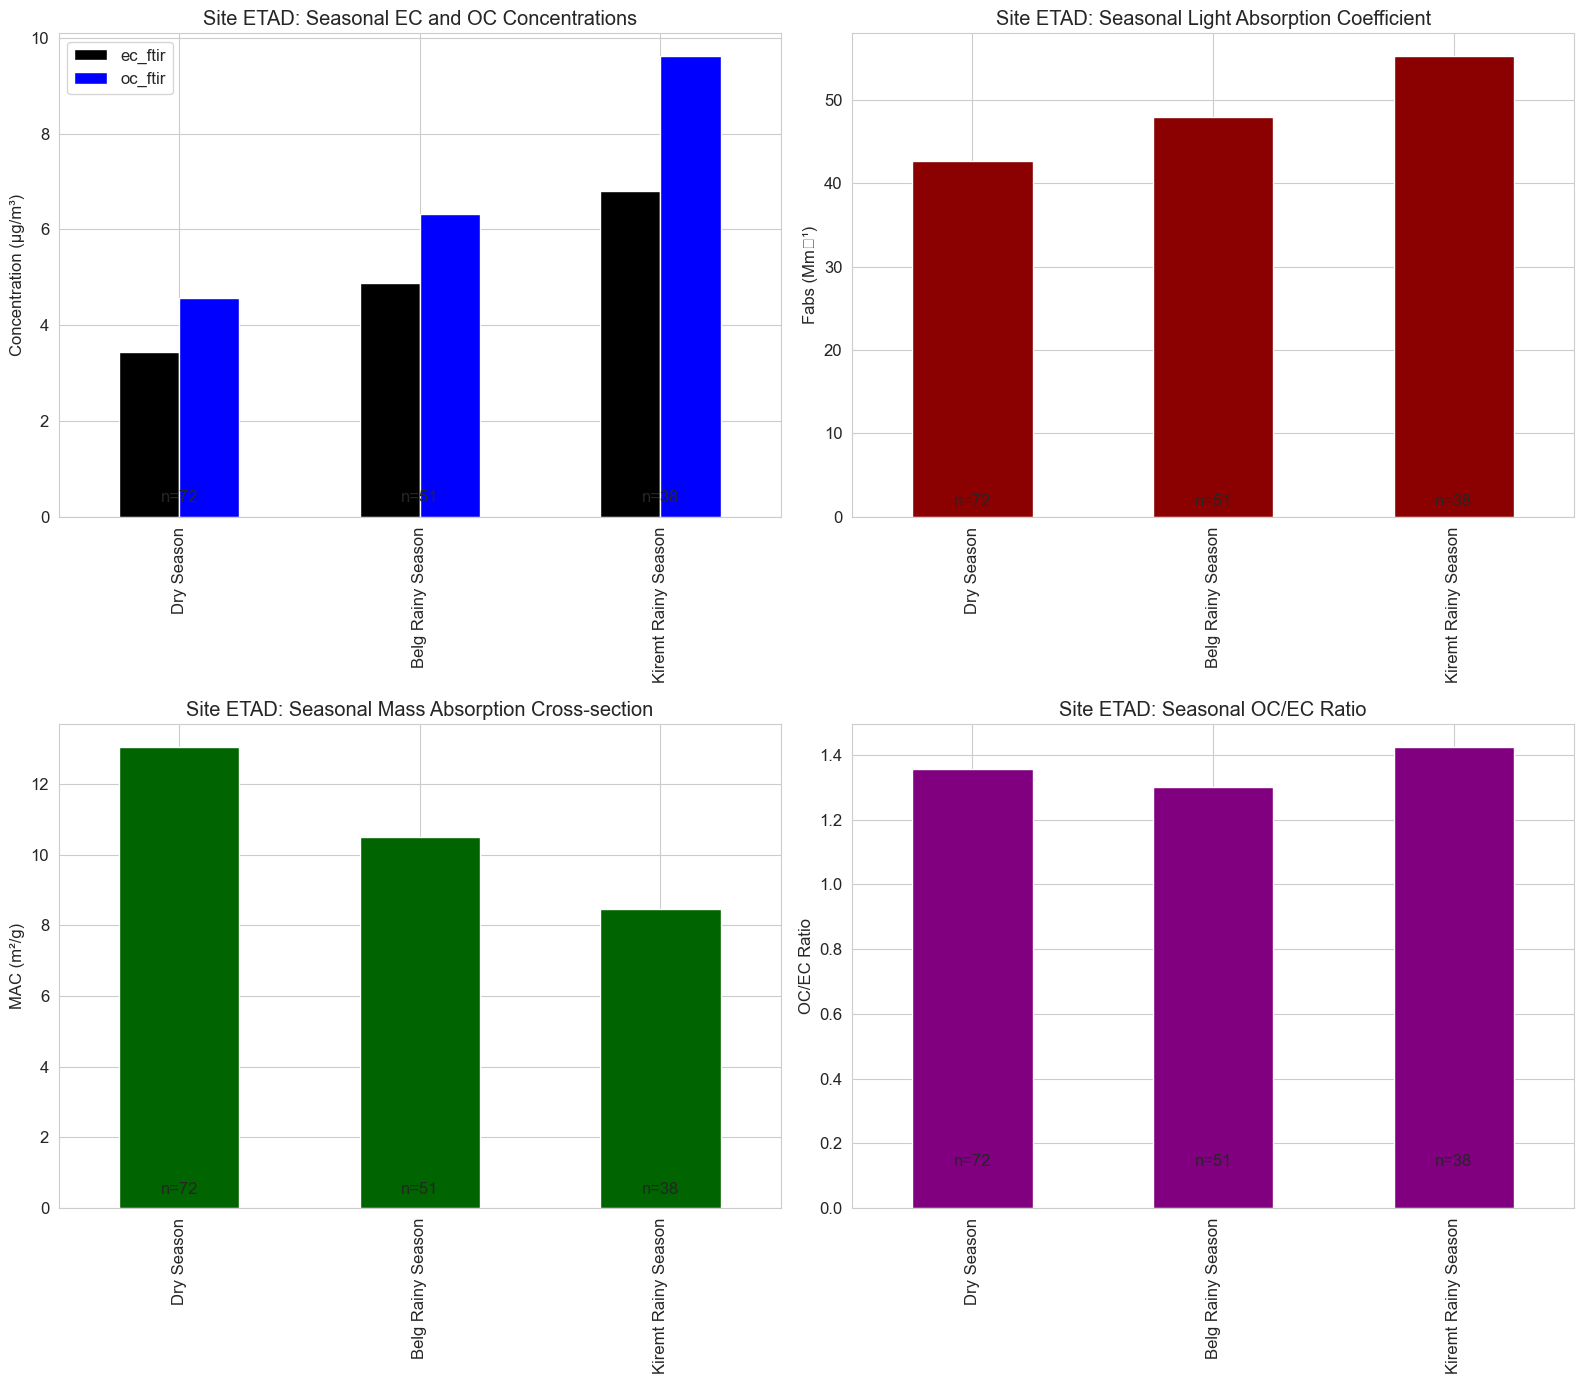

<Figure size 1200x800 with 0 Axes>

/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_46398/3188106965.py:92: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()



----- Trend Analysis -----

===== Trend Summary =====
  Metric    Mean  Annual Change  Percent Change
0     EC   4.125          0.775          18.778
1     OC   5.603          0.565          10.087
2   Fabs  45.997          0.792           1.722
3    MAC  12.285         -2.336         -19.012


/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


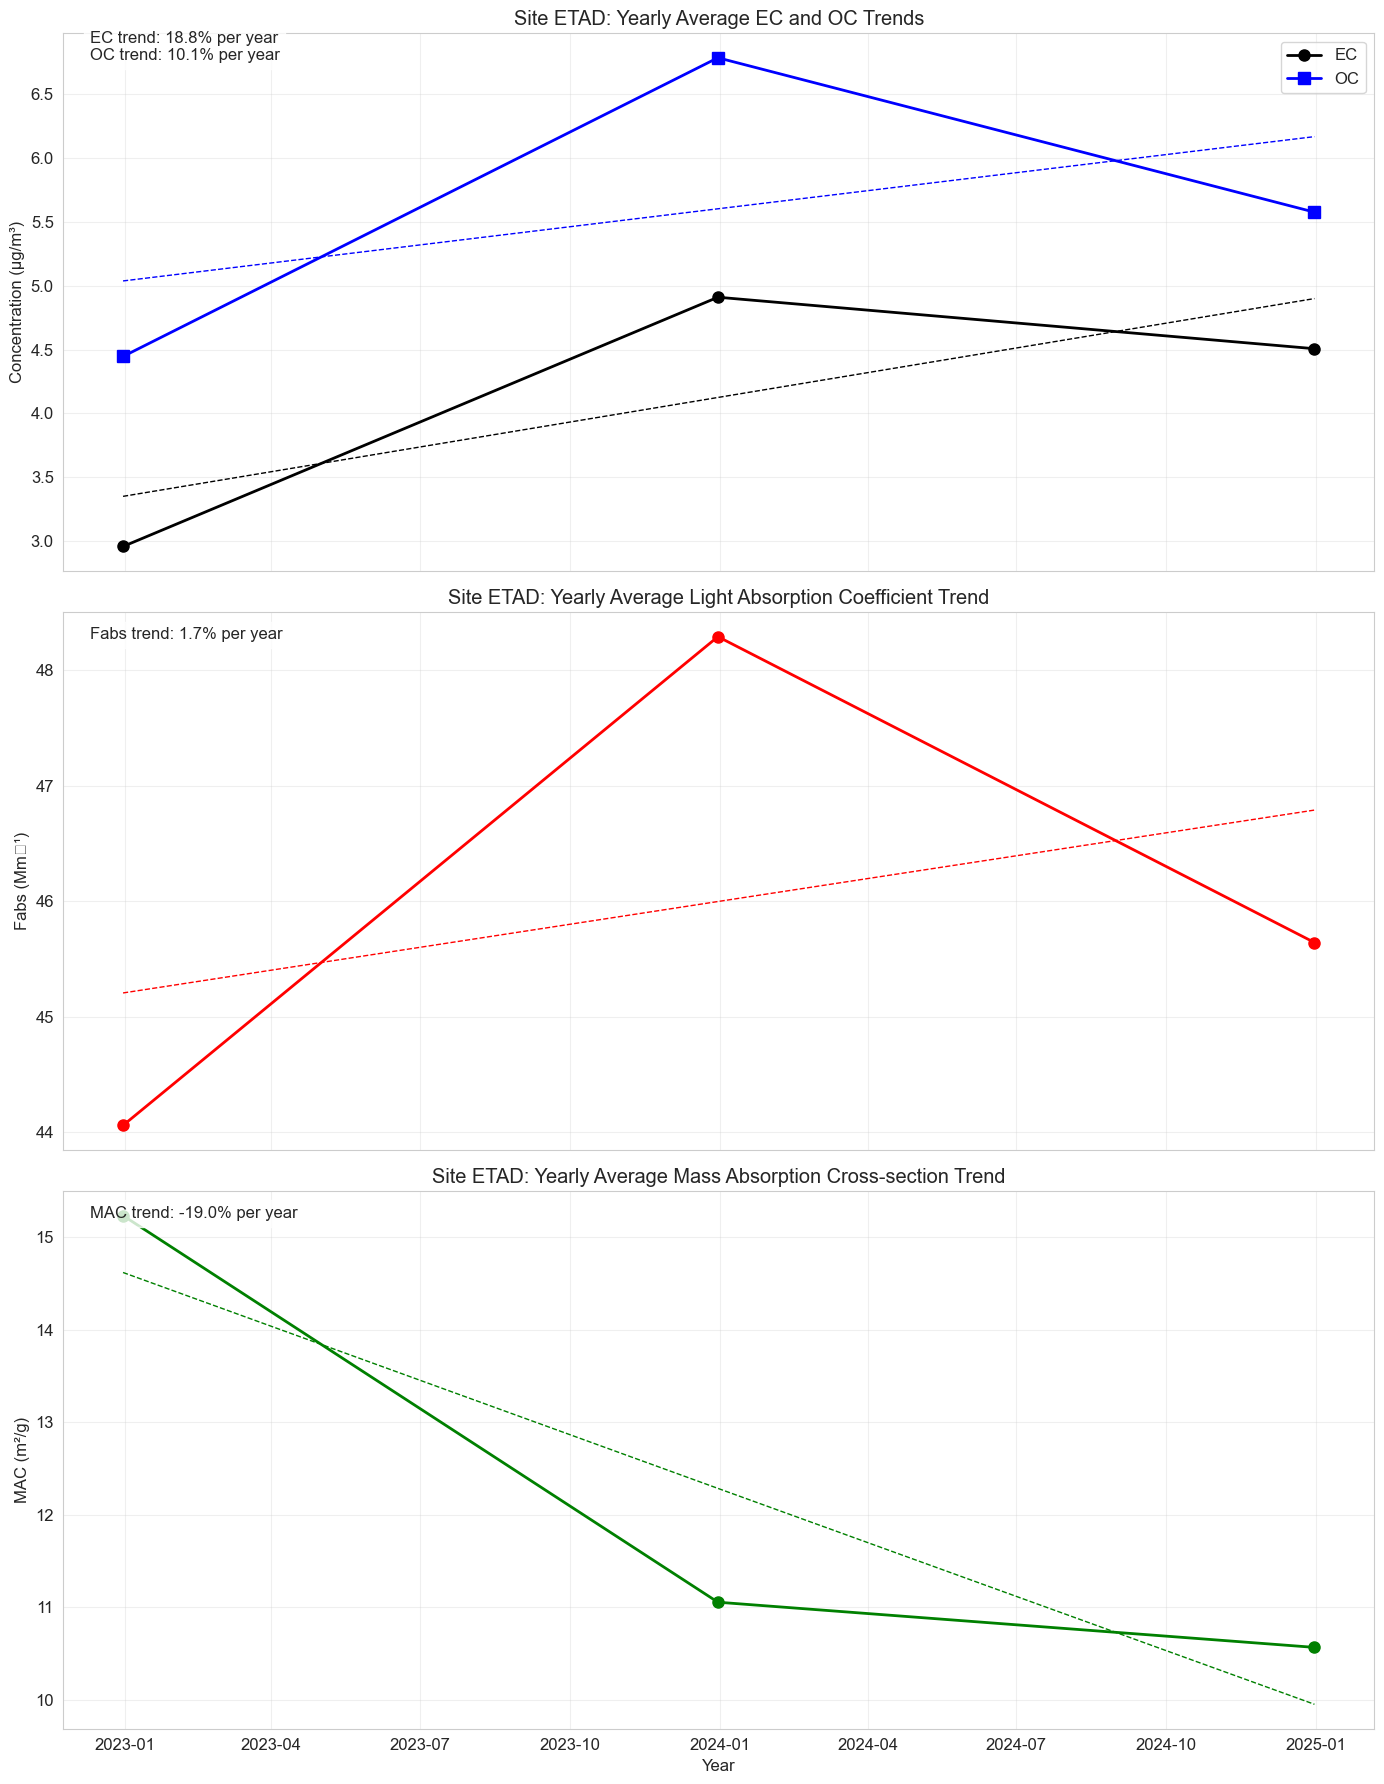


===== Summary Statistics =====

Overall Means:
ec_ftir         4.688
oc_ftir         6.317
fabs           47.314
mac            11.151
oc_ec_ratio     1.355
dtype: float64

Seasonal Means:
                     ec_ftir  oc_ftir    fabs     mac  oc_ec_ratio
season                                                            
Dry Season             3.432    4.569  42.668  13.032        1.357
Belg Rainy Season      4.882    6.330  47.989  10.502        1.300
Kiremt Rainy Season    6.808    9.612  55.210   8.458        1.424


In [38]:
# Main analysis
if __name__ == "__main__":
    # Load data for the specified site
    data = load_data_from_db(DB_PATH, SITE_OF_INTEREST)
    
    if len(data) == 0:
        print(f"No data available for site {SITE_OF_INTEREST}. Please check site code.")
        # You could list available sites or exit here
    else:
        # Explore data
        stats = explore_data(data, SITE_OF_INTEREST)
        
        # Handle values below MDL
        data_processed = handle_mdl_values(data, method='conservative')
        
        # Calculate metrics
        data_metrics = calculate_metrics(data_processed)
        
        print(f"\n===== Analysis for Site {SITE_OF_INTEREST} =====")
        print(f"Number of samples after processing: {len(data_metrics)}")
        
        # Time series analysis
        print("\n----- Time Series Analysis -----")
        fig_ts, monthly_data = analyze_time_series(data_metrics, SITE_OF_INTEREST)
        plt.show()
        
        # Correlation analysis
        print("\n----- Correlation Analysis -----")
        fig_corr = analyze_correlations(data_metrics, SITE_OF_INTEREST)
        plt.show()
        
        # Seasonal analysis
        print("\n----- Seasonal Analysis -----")
        fig_seasonal, seasonal_data = analyze_seasonal_patterns(data_metrics, SITE_OF_INTEREST)
        
        # Trend analysis
        print("\n----- Trend Analysis -----")
        fig_trend, yearly_data = analyze_trends(data_metrics, SITE_OF_INTEREST)
        plt.show()
        
        # Summary statistics
        print("\n===== Summary Statistics =====")
        print("\nOverall Means:")
        print(data_metrics[['ec_ftir', 'oc_ftir', 'fabs', 'mac', 'oc_ec_ratio']].mean().round(3))
        
        print("\nSeasonal Means:")
        print(seasonal_data[['ec_ftir', 'oc_ftir', 'fabs', 'mac', 'oc_ec_ratio']].round(3))
        